# Fall detection for the elderly 
## Probabilistic Modeling of a Physical System




We recently had the opportunity to design an algorithm for a wearable product that will detect falls in the elderly and infirm. The device incorporates a 3-axis accelerometer such as the [ADXL335](https://www.digikey.com/en/product-highlight/a/analog-devices/adxl335-small-low-power-3-axis-accelerometer?utm_adgroup=xGeneral&slid=&gclid=EAIaIQobChMI5v3hrpTY4QIVCL3sCh3SoQs6EAAYAiAAEgJMavD_BwE)
which samples a MEMS accelerometer at 50 samples/second.-



---



## Challenge: Limited Training Data

One of the unique challenges with this problem space, is the lack of training data. Collecting training data is difficult, specially in the case of false negatives where a mis-predection could make the difference between life and death. This also means that the prediction system must include a measure of uncertainity in addition to a fall/no-fall decision and a way for a system engineer to tune parameters to tradeoff
false positives versues false negatives.

Similar challenges with limited training data exist in other domains such as [space exploration ](https://medium.com/tensorflow/an-introduction-to-probabilistic-programming-now-available-in-tensorflow-probability-6dcc003ca29e)

### A Note on Deep Learning

```
Choke me in the shallow waters before I get too deep 
...
...
Dont let me get too deep

```
>#### [What I Am](https://play.google.com/music/preview/Thnidvz7tqzljivzfnprdwwuquy?play=1&u=0),  Edie Brickell & New Bohemians



There has been tremendous progress in recent years with deep learning as applied to tasks such as image recognition, machine translation or anomaly detection. However, there are several issues that limit its applicability to this problem -


1.   Need large amounts of training data, otherwise there is a tendency to overfit
2.   It is not possible to quantify uncertainty in the prediction. Recent attempts such as [Bayes by Backprop](https://arxiv.org/abs/1505.05424?context=cs) have taken a crack at this problem. However interpretability of these weight distributions still remains a challenge and being able to better quantify uncertainity in neural nets remains an area of active study.
Also see this [NIPS 2017 talk](https://youtu.be/LVBvJsTr3rg?t=1199)  by Yee Whye for more context.
3. Selecting the right neural network architecture still remains a bit of an art


One approach to building a classifier would be define the features e.g. acceleration at time *t* and then feed that into a "training machine". This does us no good, due to the limited amount of training data. What we need is a way to limit the number of parameters being trained to tackle the data sparsity issue.



---



## Physics to the Rescue!


![Acceleration Plots](https://i.imgur.com/HrdDBjc.gif  "Acceleration Plots")


From the plot[1] above we can see that -


1. The Y component of the acceleration experiences a shock effect as the subject hits the floor
2. The total acceleration tends towards zero as the subjects enters into a period of freefall.

This is true regardless of the nature of the subject, so we can use this fact to greatly simplify our model.
Instead of fitting features based on raw sample values we will attempt to model the Y-component acceleration curve during the process of falling. 



## Solution Approach

Roughly the recipe is as follows -


1.   Define a model of the physical process. 
$g_y = e^{\Theta*x}$

2.   For each data trace fit an exponential curve and extract the parameter $\Theta$

3. Setup a probabilistic model with Likelihood and Priors for the parameter $\Theta$

4. Sample the Joint Distribution to extract the distribution for the priors

5. Finally, posit a posterior with the mean defined by the physical model. Sample the posterior to generate predictions and confidence intervals





### Sample data

Since the actual training data is confidential, we synthetically generate sample data for 8 falls assuming a sampling rate of 50 $samples/sec$ ( We also assume that the sensor saturates at $2g/s$ and the least count for the sensor reading  is $g/256$ but the actual details are not important for this example )

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
tf.enable_eager_execution()
import tensorflow_probability as tfp
tfd = tfp.distributions

%load_ext autoreload
%autoreload 2
%matplotlib inline

from tensorflow_probability.python.mcmc import util as mcmc_util
import time
import math 
from scipy.optimize import curve_fit

## Setup Sample data
x_range = [0, 50] # 1 sec sample
# t_range = [0.11, 0.12] # range of theta values

# IMPORTANT: exponent values have been multiplied by 10 to prevent numeric stability issues
t_range = [0.5, 1.1] # range of theta values
n_falls = 8 # number of falls
t = t_range[0] + (t_range[1]-t_range[0])*np.random.rand(n_falls)

def func(x, a, b, c):
  return np.exp(a * x)

  
def load_dataset(n=50, theta=0.11):
  def s(x):
    return np.exp(theta*x)
  
  np.random.seed(43)
  x = np.linspace(*x_range, num=n).astype(np.int)
#   y = s(x) + np.random.rand(n)*s(x)*np.random.choice([1,-1])/2.
  y = s(x) + 4.0 * np.random.normal(size=n)
  return y, x

# generate raw data samples
raw_samples = []

# observations are sample values for ${\Theta}
observations = []
for theta in t:
  y,x = load_dataset(theta=theta)
  popt, pcov = curve_fit(func, x, y)
  observations.append(popt[0])
  raw_samples.append(y)
  
  
plt.figure(figsize=[8,5])
plt.plot(x,raw_samples[0],'b.',label='sample data',linewidth=4)
plt.legend()

# print(observations)
#plt.plot(x,raw_samples[1],'b.',label='sample',linewidth=4)

### Model Setup

For the purposes of this example, the physical model is quite simple. We model the Y-component of the gravitational acceleration as seen by the accelerometer sensor

 $g_y = e^{\Theta*x}$ 
 
We assume that ${\Theta}$ follows a Exponential distribution, since we are only interested in positive real values
${\Theta}$ ~  $Exponential(0.5)$

We also set some hyperparameters. A natural choice is the Gamma distribution, and we set it up as $Gamma(0.35,1)$ to reflect our prior knowledge of the expected value of ${\Theta}$


---

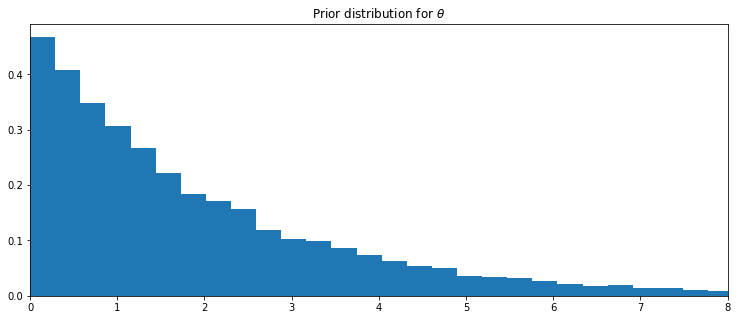

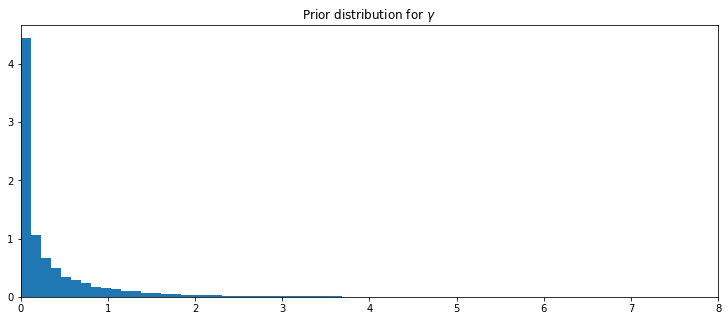

In [7]:
theta = tfd.Exponential(rate=0.5, name="theta_sample")

    
# Visualize our stepwise prior distribution
samples = theta.sample(sample_shape=20000)
plt.figure(figsize=[12.5, 5])
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title(r"Prior distribution for $\theta$")
plt.xlim(0, 8);

samples = []
alpha = 0.35 
beta  = 1.0
gamma = tfd.Gamma(concentration=alpha, rate=beta)

samples = gamma.sample(sample_shape=20000)
plt.figure(figsize=[12.5, 5])
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title(r"Prior distribution for $\gamma$")
plt.xlim(0, 8);

 ---

A useful way to visualize probabilistic models is via an inference graph
![Probabilistic Graph Model](https://i.imgur.com/lgHuSiF.png)